# セットアップ

## ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

## データの読み込み

### 訓練データの出力(購入データ)
`train_purchases.csv` \
columns: `session_id`, `item_id` \
The purchase that happened at the end of the session. One purchase per session. \
各セッションでの正解ラベル．

In [3]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


In [4]:
# それぞれの列のユニークな数を確認．item_idにはかなり重複がありそう(当たり前)
df_train_purchases.nunique()

session_id    1000000
item_id         18907
date           999969
dtype: int64

購入された件数ごとに，itemがどの程度の数あるのかを調べる．
1. 1回しか購入されていないitemも多く，このようなitemを予測することはデータ量的に難しそう．
2. ボリュームゾーンとしては$10^2$回弱購入されている様子．
3. 一方で，数少ないitemが$10^3$回以上の購入を占めていることも確認できる．

Text(0, 0.5, 'itemの件数')

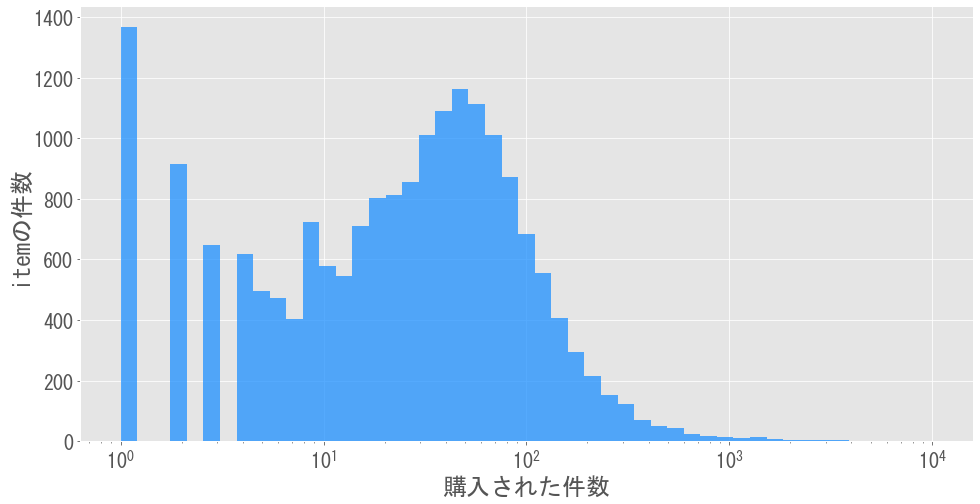

In [5]:
df_purchases_counts = df_train_purchases["item_id"].value_counts().values
ax = plt.figure(figsize = (16, 8)).add_subplot(111)
ax.hist(x = df_purchases_counts, bins = np.logspace(0, 4, 50), color = 'dodgerblue', alpha = 0.75)
ax.set_xscale('log')
ax.set_xlabel('購入された件数')
ax.set_ylabel("itemの件数")

購入した曜日や時間帯に傾向があるかを確認．

In [6]:
w_list = ["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"]
for idx in df_train_purchases.index:
    if idx % 10000 == 0:
        print(idx, " / ", len(df_train_purchases), end = "\r")
    datetime_list = re.findall(r"\d+", df_train_purchases.at[idx, "date"])
    datetime_list = [int(s) for s in datetime_list]
    df_train_purchases.at[idx, "date_as_datetime"] = datetime.datetime(datetime_list[0], datetime_list[1], datetime_list[2],\
                                                                   datetime_list[3], datetime_list[4])
    #df_train_purchases.at[idx, "date_as_datetime"] = datetime.datetime.strptime(df_train_purchases.at[idx, "date"], '%Y-%m-%d %H:%M:%S.')
    df_train_purchases.at[idx, "day_of_week"] = w_list[int(df_train_purchases.at[idx, "date_as_datetime"].weekday())]
    df_train_purchases.at[idx, "hour"] = datetime_list[3]
display(df_train_purchases)

,session_id,item_id,date,date_as_datetime,day_of_week,hour
0,3,15085,2020-12-18 21:26:47.986,2020-12-18 21:26:00,Fri,21.0
1,13,18626,2020-03-13 19:36:15.507,2020-03-13 19:36:00,Fri,19.0
2,18,24911,2020-08-26 19:20:32.049,2020-08-26 19:20:00,Wed,19.0
3,19,12534,2020-11-02 17:16:45.92,2020-11-02 17:16:00,Mon,17.0
4,24,13226,2020-02-26 18:27:44.114,2020-02-26 18:27:00,Wed,18.0
...,...,...,...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464,2021-05-13 11:56:00,Thr,11.0
999996,4439990,8786,2020-08-22 14:28:22.382,2020-08-22 14:28:00,Sat,14.0
999997,4439994,21630,2020-11-27 20:10:28.961,2020-11-27 20:10:00,Fri,20.0
999998,4439999,16962,2020-11-27 11:01:41.356,2020-11-27 11:01:00,Fri,11.0


土曜日と金曜日が多いという結果．水曜日は少ない傾向．日曜日がそれほど多くないのは少し意外な感じ．

In [7]:
df_train_purchases["day_of_week"].value_counts().to_frame().style.bar(vmin = 0, vmax = 200000)

,day_of_week
Sat,162314
Fri,160202
Tue,147825
Sun,136861
Mon,134671
Thr,130784
Wed,127343


時間帯別で集計．どの曜日でも全体的な傾向には変わりはない．\
曜日や時間帯で，注文されやすいような商品に違いがあるかも？要確認．

<AxesSubplot:xlabel='hour'>

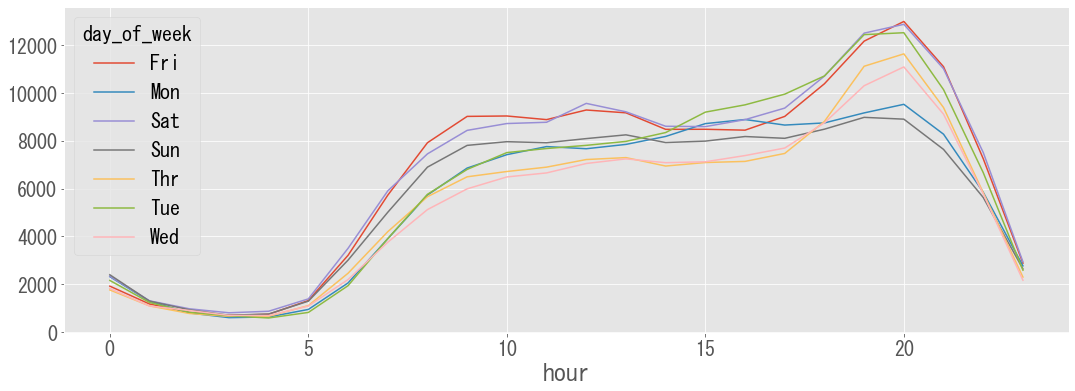

In [8]:
df_train_purchases.pivot_table(values = "session_id", index = "hour", columns = "day_of_week", aggfunc = "count").plot(figsize = (18, 6))

時間帯を表す`time_zoon`列を追加する．`morning`，`afternoon`，`eveninng`，`night`，`midnight`で分類．

In [9]:
# for文は回したくないので，関数を定義
def hour_to_timezoon(hour):
    if hour < 6.0:
        return "midnight"
    elif hour < 10.0:
        return "morning"
    elif hour < 16.0:
        return "afternoon"
    elif hour < 21.0:
        return "night"
    else:
        return "midnight"
df_train_purchases["time_zoon"] = df_train_purchases["hour"].apply(hour_to_timezoon) # 列を追加
df_train_purchases

,session_id,item_id,date,date_as_datetime,day_of_week,hour,time_zoon
0,3,15085,2020-12-18 21:26:47.986,2020-12-18 21:26:00,Fri,21.0,midnight
1,13,18626,2020-03-13 19:36:15.507,2020-03-13 19:36:00,Fri,19.0,night
2,18,24911,2020-08-26 19:20:32.049,2020-08-26 19:20:00,Wed,19.0,night
3,19,12534,2020-11-02 17:16:45.92,2020-11-02 17:16:00,Mon,17.0,night
4,24,13226,2020-02-26 18:27:44.114,2020-02-26 18:27:00,Wed,18.0,night
...,...,...,...,...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464,2021-05-13 11:56:00,Thr,11.0,afternoon
999996,4439990,8786,2020-08-22 14:28:22.382,2020-08-22 14:28:00,Sat,14.0,afternoon
999997,4439994,21630,2020-11-27 20:10:28.961,2020-11-27 20:10:00,Fri,20.0,night
999998,4439999,16962,2020-11-27 11:01:41.356,2020-11-27 11:01:00,Fri,11.0,afternoon


### 訓練データの入力(各セッションでのitemのビュー)
`train_sessions.csv`\
columns: `session_id`, `item_id`, `date`\
The items that were viewed in a session. The "date" column is a timestamp to miliseconds. A session is equal to a day, so a session is one user's activity on one day. The session goes up to and not including the first time the user viewed the item that they bought in the end. The last item in the session will be the last item viewed before viewing the item that they bought. To find they item they bought link to train_purchases.csv on session_id. \
各セッションにおいて，購入の直前まで見ていた商品の一覧が入力として与えられる．これをもとに，どの商品を購入したのかを当てる．

In [10]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


各セッションでどれだけの商品を見ているか確認．

セッションの長さの平均値： 4.74382
セッションの長さの中央値： 3.0


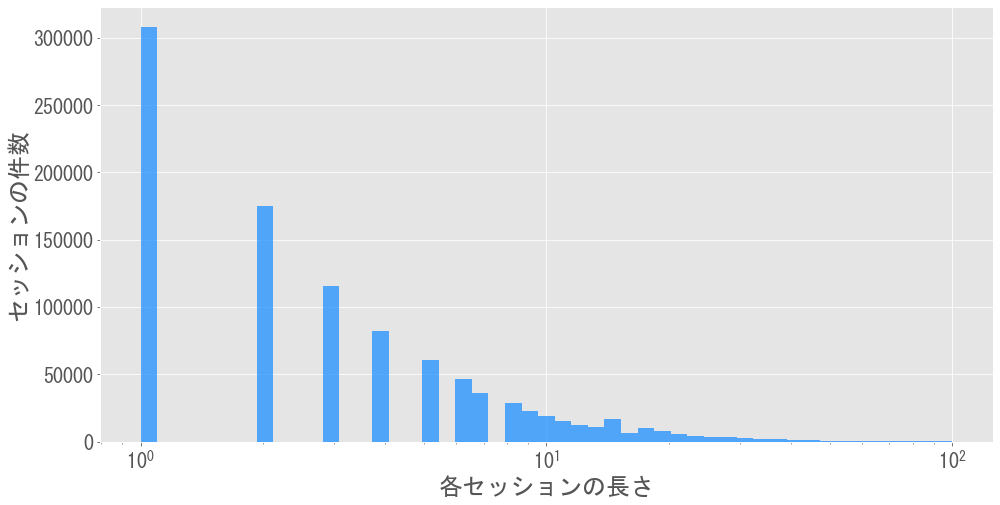

In [11]:
df_train_sessions_counts = df_train_sessions.groupby("session_id").count()["item_id"].values
ax = plt.figure(figsize = (16, 8)).add_subplot(111)
ax.hist(x = df_train_sessions_counts, bins = np.logspace(0, 2, 50), color = 'dodgerblue', alpha = 0.75)
ax.set_xscale('log')
ax.set_xlabel('各セッションの長さ')
ax.set_ylabel("セッションの件数")

print("セッションの長さの平均値：", df_train_sessions_counts.mean())
print("セッションの長さの中央値：", np.median(df_train_sessions_counts))

### 特徴量データ
`item_features.csv`
columns: `item_id`, `feature_category_id`, `feature_value_id`
The label data of items. A feature_category_id represents an aspect of the item such as "colour", the feature_value_id is the value for that aspect, e.g. "blue". Some items may not share many feature_cateogry_ids if they different types of items, for example trousers will share almost nothing with shirts. Even things like colour will not be shared, the colour aspect for trousers and shirts are two different feature_category_ids.\
各itemが持っている特徴量をまとめている．`colour`のような特徴であっても，商品ごとに異なる特徴量idが振られているため，異なる商品の間では共通の特徴量idはあまり持っていなさそう．

In [12]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
display(df_item_features)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


共通して用いられている特徴量もそれなりにありそう．上位の特徴量は要チェック．

In [13]:
df_item_features["feature_category_id"].value_counts()

56    23691
47    23691
50    23077
68    23038
61    22512
      ...  
52      568
54      341
13      137
9       137
27        1
Name: feature_category_id, Length: 73, dtype: int64

itemと特徴量の共起行列`df_item_features_pivot`を作成する．

In [14]:
# pivotで共起行列を生成
df_item_features_pivot = df_item_features.pivot_table(values = "feature_value_id", index = "item_id", columns = "feature_category_id", aggfunc = "count")
df_item_features_pivot.fillna(0.0, inplace = True) # 標準化のためnaを0で埋める
display(df_item_features_pivot)

feature_category_id,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
28140,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
28141,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


### 主成分分析
特異値分解より主成分分析の方がわかりやすいため，こちらに修正．
よく確認するとすべてのitemに対して0が入っているような特徴量(`47`, `56`)があったため，要注意．

In [15]:
df_item_features_pca = df_item_features_pivot.apply(lambda x:  (x - x.mean()) / x.std(), axis = 0) # PCAのため，各列のデータを標準化(自動で標準化してほしい)
print("==============すべてのitemに対し，0が入っているのはこの特徴量たち==============")
display(df_item_features_pca.loc[:,df_item_features_pca.isnull().any()]) # すべてのitemに対し0であるような列の場所を確認
df_item_features_pca.fillna(0.0, inplace = True) # すべてのitemに対し0であるような列は標準化がうまくいかずNaNが生じるため，このタイミングで再度fillnaする必要あり

# 主成分分析
pca = PCA()
pca.fit(df_item_features_pca)
feature = pca.transform(df_item_features_pca)
print("==============すべての商品に対しPCAした結果は以下==============")
df_item_features_pca = pd.DataFrame(feature, columns = ["PC{}".format(x + 1) for x in range(len(df_item_features_pca.columns))], index = df_item_features_pivot.index)
display(df_item_features_pca)

==============すべてのitemに対し，0が入っているのはこの特徴量たち==============


feature_category_id,47,56
item_id,,
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
7,NaN,NaN
8,NaN,NaN
...,...,...
28139,NaN,NaN
28140,NaN,NaN
28141,NaN,NaN


==============すべての商品に対しPCAした結果は以下==============


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
item_id,,,,,,,,,,,,,,,,,,,,,
2,1.144286,4.898230,1.275359,-1.418253,-0.923467,-1.098312,-1.010635,0.597694,-0.053258,0.231783,...,9.397856e-16,3.123049e-16,-6.372346e-16,6.099536e-16,6.900599e-16,4.510124e-17,2.424824e-16,2.758988e-16,5.299967e-18,-4.039210e-16
3,-3.031435,-2.626924,-1.479996,0.262581,-1.884794,0.602081,0.341404,0.467904,0.030879,-0.709510,...,4.477922e-16,-1.317667e-15,-4.888278e-16,-7.150993e-16,-2.608191e-16,-2.248476e-16,-1.780166e-16,1.066343e-16,6.855645e-18,1.497430e-16
4,-3.031960,-2.646060,-1.586152,0.597622,-1.663302,0.657132,0.662329,0.127210,0.050265,-0.488979,...,-1.162031e-15,1.763202e-15,5.936397e-16,-1.603278e-15,4.330703e-16,-5.579145e-16,1.689281e-16,-6.683803e-17,6.421964e-18,2.134267e-15
7,-0.600343,0.462306,0.401003,-3.268140,2.723118,-1.502795,-1.098952,-1.028245,-0.049853,-0.041947,...,5.165131e-16,1.707023e-15,7.470747e-16,5.804633e-16,6.310793e-16,1.630624e-16,2.563602e-16,-7.104592e-17,-4.654365e-18,-1.382305e-15
8,-3.031435,-2.626924,-1.479996,0.262581,-1.884794,0.602081,0.341404,0.467904,0.030879,-0.709510,...,4.477922e-16,-1.317667e-15,-4.888278e-16,-7.150993e-16,-2.608191e-16,-2.248476e-16,-1.780166e-16,1.066343e-16,6.855645e-18,1.497430e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,-2.831317,-1.947513,-1.897988,0.079155,2.951142,-1.036028,0.204185,-1.817494,0.061519,0.119988,...,8.849426e-16,-1.456445e-15,1.148751e-15,6.545665e-18,6.273593e-16,2.495261e-17,-3.923873e-17,-2.607203e-17,-7.225430e-18,-6.482298e-16
28140,10.627412,-2.852589,-0.781851,1.014092,0.042694,-0.043397,0.213826,0.014530,7.037379,0.111119,...,-1.086620e-15,1.263672e-15,5.587013e-16,1.631569e-15,-3.324310e-16,2.859731e-16,-1.638272e-17,8.435514e-17,-2.973830e-18,-1.658510e-15
28141,-2.810719,-2.614798,0.667391,0.886746,-1.411277,-0.106180,0.028229,0.039142,0.006052,6.922311,...,1.356787e-15,-2.039312e-15,8.711954e-16,1.394324e-15,-1.220412e-16,-3.636254e-16,-2.196500e-16,-1.826578e-17,-6.330964e-18,9.407769e-16


いくつかの主成分について，itemをプロットしてみる．それなりにいい感じに分かれていそう．itemは4~5つのカテゴリに落とすのが良いかも．

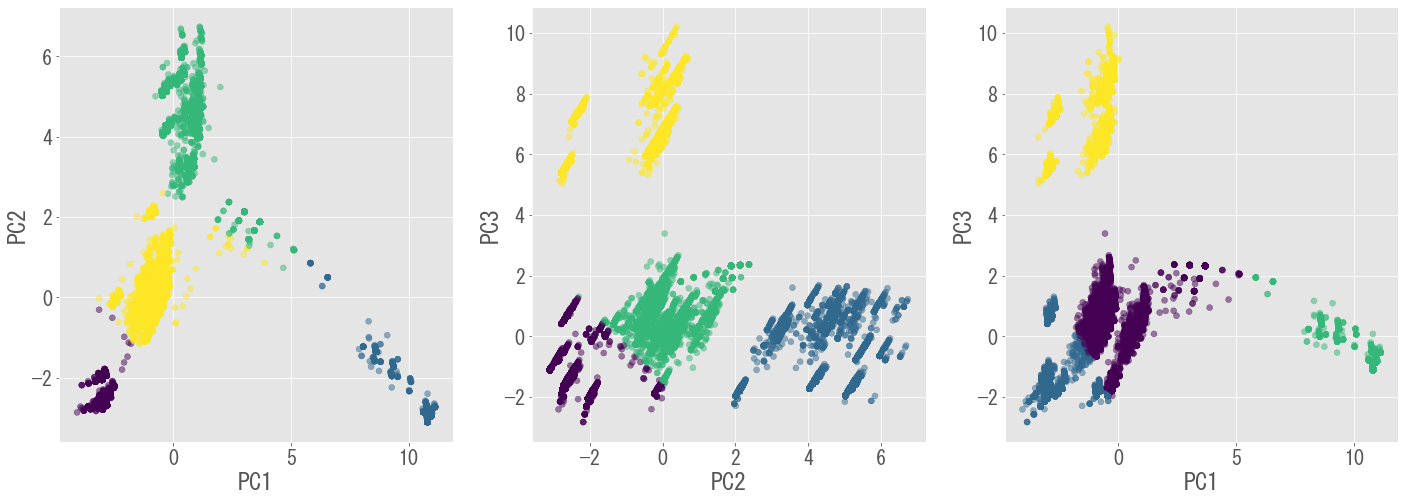

In [16]:
pca_pair_list = [["PC1", "PC2"], ["PC2", "PC3"], ["PC1", "PC3"]]

fig = plt.figure(figsize = (24, 8))

for idx, pair in enumerate(pca_pair_list):
    pred = KMeans(n_clusters = 4).fit_predict(df_item_features_pca[pair].values) # 2次元に落とした結果をクラスタリング．
    ax = fig.add_subplot(1, len(pca_pair_list), idx + 1)
    pca_x, pca_y = pair # x軸とy軸
    ax.scatter(df_item_features_pca[pca_x], df_item_features_pca[pca_y], alpha = 0.5, c = pred)
    ax.set_xlabel(pca_x)
    ax.set_ylabel(pca_y)

各主成分の固有値はどのような感じかチェック．$60$次元で$10^{-5}$のオーダーくらい小さくなるので，$10$次元くらいまで取れば十分かも?

Text(0, 0.5, '各固有ベクトルの固有値')

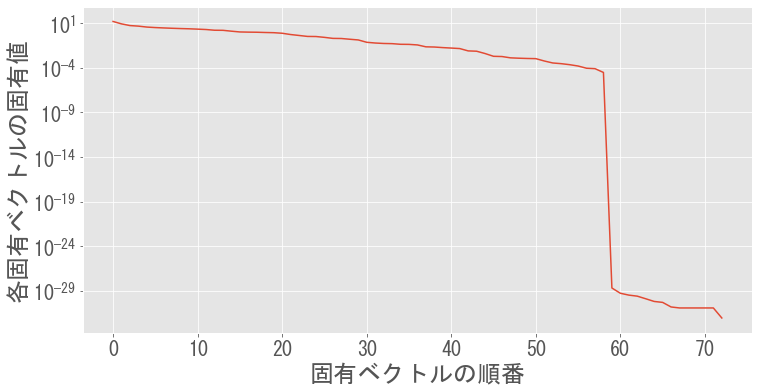

In [17]:
ax = plt.figure(figsize = (12, 6)).add_subplot(1, 1, 1)
ax.plot(np.arange(len(pca.explained_variance_)), pca.explained_variance_)
ax.set_yscale("log")
ax.set_xlabel('固有ベクトルの順番')
ax.set_ylabel("各固有ベクトルの固有値")

`pca.components_`は，特徴量の空間で主成分ベクトルを表示したものになっている．ここから，主成分に各特徴量がどのように効いているのかも見ることができる．

In [18]:
df_pca_components = pd.DataFrame(pca.components_, index = ["PC{}".format(x + 1) for x in range(len(df_item_features_pca.columns))], columns = df_item_features_pivot.columns)
display(df_pca_components)

feature_category_id,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
PC1,-0.023394,2.165792e-01,-1.456090e-01,-1.501663e-01,-1.458714e-01,0.001295,-2.239744e-01,-0.034693,-0.010033,-0.028879,...,0.102865,-1.238605e-01,1.305715e-01,2.273366e-01,-3.779181e-02,-2.243642e-01,-1.842687e-02,0.102865,-2.245493e-01,-7.118647e-02
PC2,-0.035569,-1.100106e-01,-2.147906e-01,-2.298900e-02,-2.143115e-01,0.166154,8.166191e-02,-0.052466,-0.016375,-0.046227,...,-0.042558,-4.597550e-02,-6.713569e-02,-1.108909e-01,-3.545539e-02,8.290098e-02,-2.483497e-02,-0.042558,8.504986e-02,-7.174397e-02
PC3,0.041886,-4.892108e-02,-6.741413e-02,-1.338379e-01,-5.609535e-02,-0.055085,5.381685e-03,0.361794,0.012740,0.240813,...,-0.005829,-2.565515e-01,-3.233983e-02,-4.368897e-02,-6.745757e-02,6.882304e-03,2.638082e-01,-0.005829,9.482521e-03,-1.329023e-01
PC4,-0.040111,8.014241e-02,1.203154e-01,2.455212e-01,1.164299e-01,0.104425,1.914804e-02,0.184697,-0.001425,0.134893,...,0.000380,1.001381e-01,5.607725e-02,6.822367e-02,1.617500e-01,1.583623e-02,1.204791e-01,0.000380,1.033442e-02,2.566115e-01
PC5,-0.072807,-2.853438e-03,-3.619781e-02,1.585839e-03,-3.035096e-02,-0.080720,6.478619e-03,0.053064,-0.027883,0.004979,...,0.000660,5.396816e-02,-2.456179e-03,-2.650991e-03,8.304721e-03,6.336265e-03,7.471361e-02,0.000660,6.272604e-03,4.996366e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC69,-0.000000,-7.144092e-17,-1.225567e-16,2.292462e-16,-8.978552e-17,-0.003727,4.579806e-16,0.034162,0.161680,-0.060733,...,0.148484,-2.220446e-16,6.245005e-17,-2.393918e-16,9.540979e-17,-5.689893e-16,-5.414914e-02,-0.148484,-2.749537e-16,4.163336e-17
PC70,-0.000000,-2.037486e-16,-4.860198e-17,1.301133e-16,-5.449337e-17,0.000959,-1.442565e-16,-0.014877,0.073050,-0.020293,...,0.640707,-2.914335e-16,7.199102e-17,-6.938894e-17,1.387779e-16,-2.168404e-16,-5.342169e-03,-0.640707,1.682682e-16,-4.336809e-17
PC71,-0.000000,3.670602e-18,8.971818e-17,-4.982073e-17,-7.160006e-17,0.000520,1.442497e-16,0.003735,0.024337,0.006788,...,-0.039119,-1.040834e-17,1.639314e-16,1.205633e-16,-6.071532e-17,1.647987e-17,7.293653e-04,0.039119,8.673617e-18,2.574980e-17
PC72,0.000000,-1.446924e-17,5.022573e-18,-7.141090e-18,-7.181383e-18,0.000284,3.281914e-17,0.000348,0.004077,0.000856,...,-0.000192,-4.336809e-18,7.394259e-17,4.369335e-17,-2.168404e-19,8.239937e-18,-8.347985e-07,0.000192,-6.776264e-21,2.439455e-19


`PC1`と`PC2`について，それぞれの特徴量がどのように効いているのかを確認する．これは特徴量を分類するのに使えそう?(どのように活かすのかはわからないが)

Text(0, 0.5, 'PC2')

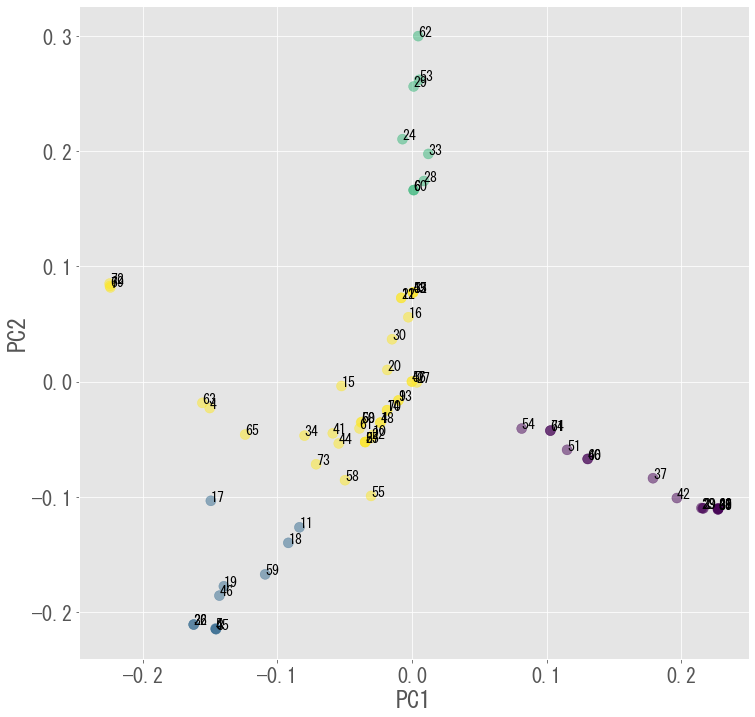

In [19]:
pred = KMeans(n_clusters = 4).fit_predict(pca.components_[[0,1]].T) # 2次元に落とした結果をクラスタリング．

ax = plt.figure(figsize = (12, 12)).add_subplot(1, 1, 1)

# 第一主成分と第二主成分における観測変数の寄与度をプロットする
for x, y, name in zip(pca.components_[0], pca.components_[1], df_item_features_pivot.columns.values):
    ax.text(x, y, name, fontsize = 14)
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5, c = pred, s = 100.0)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

### アイテムデータ
`candidate_items.csv`
columns: `item_id`
The candidate items to recommend from. This is one list for both the validation and test set.\
購入に至っていないようなアイテムもあったような気がする(要確認)．

In [20]:
df_candidate_items = pd.read_csv(path_data + r"\candidate_items.csv")
display(df_candidate_items)

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


# データを確認して思いついたこと
## マルコフ連鎖
itemのビューが時系列として与えられるため，マルコフ連鎖的な形で予測ができる？\
ただビューが各セッションでばらついているため，そこは工夫する必要があるかもしれない．
## 特徴量の候補
* 時間帯，曜日
* 商品のカテゴリ(クラスタリングによって生成)
* ビューの時間間隔
* itemのビューの共起行列(?)

# 正解ラベルとの相関分析

## 時間との関係
時間帯や曜日ごとに，購入する商品に傾向があるかを調査する．ただ，実際の予測では「購入時の」時間は与えられないため，購入直前のビューなどで近似する必要があることには注意(多分)．

In [21]:
df_train_purchases

,session_id,item_id,date,date_as_datetime,day_of_week,hour,time_zoon
0,3,15085,2020-12-18 21:26:47.986,2020-12-18 21:26:00,Fri,21.0,midnight
1,13,18626,2020-03-13 19:36:15.507,2020-03-13 19:36:00,Fri,19.0,night
2,18,24911,2020-08-26 19:20:32.049,2020-08-26 19:20:00,Wed,19.0,night
3,19,12534,2020-11-02 17:16:45.92,2020-11-02 17:16:00,Mon,17.0,night
4,24,13226,2020-02-26 18:27:44.114,2020-02-26 18:27:00,Wed,18.0,night
...,...,...,...,...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464,2021-05-13 11:56:00,Thr,11.0,afternoon
999996,4439990,8786,2020-08-22 14:28:22.382,2020-08-22 14:28:00,Sat,14.0,afternoon
999997,4439994,21630,2020-11-27 20:10:28.961,2020-11-27 20:10:00,Fri,20.0,night
999998,4439999,16962,2020-11-27 11:01:41.356,2020-11-27 11:01:00,Fri,11.0,afternoon


### 曜日ごとに集計

In [22]:
day_of_week_list = ["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"]
df_train_purchases_pivot = df_train_purchases.pivot_table(values = "session_id", index = "item_id", columns = "day_of_week", aggfunc = "count")
df_train_purchases_pivot = df_train_purchases_pivot.reindex(columns = day_of_week_list).fillna(0).copy()

曜日ごとによく買われている商品のランキングとその回数をまとめる．

In [23]:
# ランキング形式でまとめるテーブル
df_rank = pd.DataFrame(index = range(1, len(df_train_purchases_pivot)+1)) # ランクにするため，+1する必要あり
for dow in day_of_week_list:
    df_rank[dow + "_item"] = df_train_purchases_pivot[dow].sort_values(ascending = False).index
    # 回数もcountとしてまとめることができるが，見づらいのでコメントアウト
    df_rank[dow + "_count"] = df_train_purchases_pivot[dow].sort_values(ascending = False).values.astype("int")
df_rank["all_item"] = df_train_purchases_pivot.sum(axis = 1).sort_values(ascending = False).index
df_rank["all_count"] = df_train_purchases_pivot.sum(axis = 1).sort_values(ascending = False).values.astype("int")
df_rank.head(10).to_excel("rank_曜日ごと.xlsx")
df_rank.head(10)

,Mon_item,Mon_count,Tue_item,Tue_count,Wed_item,Wed_count,Thr_item,Thr_count,Fri_item,Fri_count,Sat_item,Sat_count,Sun_item,Sun_count,all_item,all_count
1,8060,1128,8060,1435,8060,1101,8060,870,8060,1297,8060,1336,8060,1284,8060,8451
2,19882,630,26853,526,26853,494,26853,567,26853,676,26853,591,2447,482,26853,3829
3,26853,498,19882,457,19882,428,19882,413,19882,456,19882,530,26853,477,19882,3355
4,4193,373,8622,432,8622,384,8622,395,2447,456,2447,524,19882,441,8622,2745
5,11742,320,18156,415,20770,312,4193,292,8622,441,18156,465,20770,397,2447,2726
6,20770,314,2447,406,4193,288,2447,284,17089,390,8622,456,4193,351,4193,2416
7,2447,302,4193,378,2447,272,20770,260,4193,362,4028,436,8622,344,20770,2349
8,8622,293,20770,370,18156,247,17089,237,20770,349,17089,397,18156,329,18156,2308
9,18156,287,15501,333,21215,226,27225,232,11742,345,4193,372,15501,271,17089,2032
10,7963,280,1644,328,2915,221,21215,230,18156,342,20770,347,11742,269,1644,1879


### 時間帯ごとに集計

In [24]:
time_zoon_list = ["morning", "afternoon", "night", "midnight"]
df_train_purchases_pivot = df_train_purchases.pivot_table(values = "session_id", index = "item_id", columns = "time_zoon", aggfunc = "count")
df_train_purchases_pivot = df_train_purchases_pivot.reindex(columns = time_zoon_list).fillna(0).copy()

In [25]:
# ランキング形式でまとめるテーブル
df_rank = pd.DataFrame(index = range(1, len(df_train_purchases_pivot)+1)) # ランクにするため，+1する必要あり
for time_zoon in time_zoon_list:
    df_rank[time_zoon + "_item"] = df_train_purchases_pivot[time_zoon].sort_values(ascending = False).index
    # 回数もcountとしてまとめることができるが，見づらいのでコメントアウト
    df_rank[time_zoon + "_count"] = df_train_purchases_pivot[time_zoon].sort_values(ascending = False).values.astype("int")
df_rank["all_item"] = df_train_purchases_pivot.sum(axis = 1).sort_values(ascending = False).index
df_rank["all_count"] = df_train_purchases_pivot.sum(axis = 1).sort_values(ascending = False).values.astype("int")
df_rank.head(10).to_excel("rank_時間帯ごと.xlsx")
df_rank.head(10)

,morning_item,morning_count,afternoon_item,afternoon_count,night_item,night_count,midnight_item,midnight_count,all_item,all_count
1,8060,1118,8060,2799,8060,2977,8060,1557,8060,8451
2,26853,539,26853,1419,26853,1275,26853,596,26853,3829
3,2447,383,19882,1203,19882,1213,19882,592,19882,3355
4,8622,380,8622,959,8622,996,2447,476,8622,2745
5,19882,347,2447,926,2447,941,18156,426,2447,2726
6,18156,332,4193,861,4193,856,20770,422,4193,2416
7,4193,317,20770,799,20770,818,8622,410,20770,2349
8,20770,310,18156,786,18156,764,4193,382,18156,2308
9,11742,294,17089,683,17089,737,15501,370,17089,2032
10,17089,272,11742,672,27225,654,1644,366,1644,1879


時間ごとの集計ではそれほどクリアな傾向は出なかった(悲しい)．
かろうじて分かったことは，
①8060と26853はどの曜日・時間帯でもよく買われている
②2477は日曜日に買われがち？
③19882は朝には買われにくい？(サンプル数少ないので単にゆらぎかも)
という感じ．

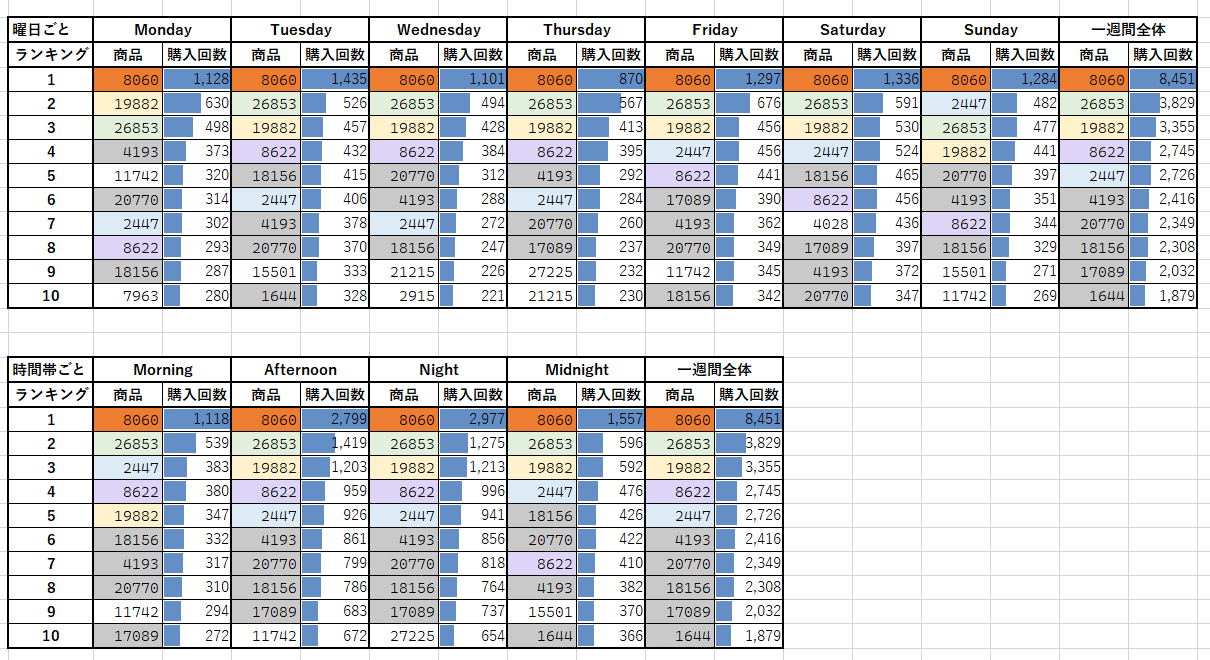

# ナイーブなモデル

In [26]:
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


## 1. 順位表をそのまま出力

In [27]:
# 順位表を作成
num_prediction_list = 100 # 100位までを出力
df_rank_table = pd.DataFrame(columns = ["item_id", "rank"])
df_rank_table["item_id"] = df_rank["all_item"].values[0:num_prediction_list]
df_rank_table["rank"] = range(1, num_prediction_list+1, 1)
df_rank_table

,item_id,rank
0,8060,1
1,26853,2
2,19882,3
3,8622,4
4,2447,5
...,...,...
95,11491,96
96,15403,97
97,12958,98
98,13296,99


In [28]:
# pandasはcross_joinがないらしい(マジ？)
def cross_join(df_a, df_b, common_key=None):
    # 同じ列名を持つ場合にはうまく動かないので注意
    df_a['tmp'] = 1
    df_b['tmp'] = 1
    return pd.merge(df_a, df_b, how='outer').drop("tmp", axis = 1)

# 順位表に基づいてpredictionする関数を作成
def predict_by_rank_table(df_test):
    session_id_list = df_test["session_id"].unique()
    df_pred = pd.DataFrame(columns = ["session_id"])
    df_pred["session_id"] = session_id_list
    return cross_join(df_pred, df_rank_table)

df_submit = predict_by_rank_table(df_test_leaderboard)
path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\rank_table.csv", index = False)

In [29]:
df_submit

,session_id,item_id,rank
0,26,8060,1
1,26,26853,2
2,26,19882,3
3,26,8622,4
4,26,2447,5
...,...,...,...
4999995,4439757,11491,96
4999996,4439757,15403,97
4999997,4439757,12958,98
4999998,4439757,13296,99


スコアは0.01626522346478938，順位は1,101位

# 2. PCAをベースとした距離を定義

`item_id`は答えにならないはずなので，それ以外で最も近いものを見つける．

In [30]:
df_item_features_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
item_id,,,,,,,,,,,,,,,,,,,,,
2,1.144286,4.898230,1.275359,-1.418253,-0.923467,-1.098312,-1.010635,0.597694,-0.053258,0.231783,...,9.397856e-16,3.123049e-16,-6.372346e-16,6.099536e-16,6.900599e-16,4.510124e-17,2.424824e-16,2.758988e-16,5.299967e-18,-4.039210e-16
3,-3.031435,-2.626924,-1.479996,0.262581,-1.884794,0.602081,0.341404,0.467904,0.030879,-0.709510,...,4.477922e-16,-1.317667e-15,-4.888278e-16,-7.150993e-16,-2.608191e-16,-2.248476e-16,-1.780166e-16,1.066343e-16,6.855645e-18,1.497430e-16
4,-3.031960,-2.646060,-1.586152,0.597622,-1.663302,0.657132,0.662329,0.127210,0.050265,-0.488979,...,-1.162031e-15,1.763202e-15,5.936397e-16,-1.603278e-15,4.330703e-16,-5.579145e-16,1.689281e-16,-6.683803e-17,6.421964e-18,2.134267e-15
7,-0.600343,0.462306,0.401003,-3.268140,2.723118,-1.502795,-1.098952,-1.028245,-0.049853,-0.041947,...,5.165131e-16,1.707023e-15,7.470747e-16,5.804633e-16,6.310793e-16,1.630624e-16,2.563602e-16,-7.104592e-17,-4.654365e-18,-1.382305e-15
8,-3.031435,-2.626924,-1.479996,0.262581,-1.884794,0.602081,0.341404,0.467904,0.030879,-0.709510,...,4.477922e-16,-1.317667e-15,-4.888278e-16,-7.150993e-16,-2.608191e-16,-2.248476e-16,-1.780166e-16,1.066343e-16,6.855645e-18,1.497430e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,-2.831317,-1.947513,-1.897988,0.079155,2.951142,-1.036028,0.204185,-1.817494,0.061519,0.119988,...,8.849426e-16,-1.456445e-15,1.148751e-15,6.545665e-18,6.273593e-16,2.495261e-17,-3.923873e-17,-2.607203e-17,-7.225430e-18,-6.482298e-16
28140,10.627412,-2.852589,-0.781851,1.014092,0.042694,-0.043397,0.213826,0.014530,7.037379,0.111119,...,-1.086620e-15,1.263672e-15,5.587013e-16,1.631569e-15,-3.324310e-16,2.859731e-16,-1.638272e-17,8.435514e-17,-2.973830e-18,-1.658510e-15
28141,-2.810719,-2.614798,0.667391,0.886746,-1.411277,-0.106180,0.028229,0.039142,0.006052,6.922311,...,1.356787e-15,-2.039312e-15,8.711954e-16,1.394324e-15,-1.220412e-16,-3.636254e-16,-2.196500e-16,-1.826578e-17,-6.330964e-18,9.407769e-16


In [61]:
# 主成分空間上での距離を定義し，近いものをリストアップする関数
def search_nearest_neighborhood_by_pca(item_id_list, num_prediction_list = 100):
    mean_vec = df_item_features_pca.loc[item_id_list].mean(axis = 0).values # ビューに含まれる各itemについて，主成分空間の座標の重心を計算
    # lambda式よりもこちらの方が圧倒的に速い．
    df_item_features_pca_minus_mean = df_item_features_pca - mean_vec # 主成分空間において，どれだけ離れているかを計算
    df_item_features_pca_distance = df_item_features_pca_minus_mean * df_item_features_pca_minus_mean # 各成分を二乗
    # 主成分について和をとることで，二乗距離を計算．ついでにソート．
    df_item_features_pca_distance = df_item_features_pca_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
    df_item_features_pca_distance.drop(index = item_id_list, inplace = True) # viewに入っているものは答えにならないはずなので，dropしておく
    return df_item_features_pca_distance[0: num_prediction_list].index.values


# 主成分空間上の距離に基づいてpredictionする
def predict_by_pca(df_test):
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"])
    session_id_list = df_test["session_id"].unique()
    #df_pred["session_id"] = pd.Series(session_id_list).repeat(num_prediction_list) # 縦につなげていくと時間がかかりそうなので，初めに空の容器を作る
    
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction_list))
    df_pred["session_id"] = np.repeat(session_id_list, num_prediction_list, axis = 0)
    df_pred["rank"] = np.tile(range(1, num_prediction_list), len(session_id_list))
    item_id_values = np.zeros(len(df_pred))
    
    # print(session_id_list)
    for idx, session_id in enumerate(session_id_list):
        if idx % 100 == 0:
            print(idx, "/", len(session_id_list), end = "\r")
        item_id_list = df_test[df_test["session_id"] == session_id]["item_id"].values
        pred_list = search_nearest_neighborhood_by_pca(item_id_list)
        
        item_id_values[idx*num_prediction_list: (idx+1)*num_prediction_list] = np.array(pred_list)
        # df_pred.loc[idx*num_prediction_list:(idx+1)*num_prediction_list, "item_id"] = pred_list
        # df_pred.loc[idx*num_prediction_list:(idx+1)*num_prediction_list-1, "rank"] = range(num_prediction_list)
        
        # df_pred.loc[df_pred["session_id"] == session_id, "item_id"] = pred_list
        # df_pred.loc[df_pred["session_id"] == session_id, "rank"] = range(1, num_prediction_list+1, 1)
        
    df_pred["item_id"] = item_id_values
    df_pred["item_id"] = df_pred["item_id"].astype("int")
    return df_pred


df_submit = predict_by_pca(df_test_leaderboard)
# df_submit["rank"] = df_submit["rank"] + 1

path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\nearest_neighborhood_by_pca.csv", index = False)

In [65]:
path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\nearest_neighborhood_by_pca.csv", index = False)
display(df_submit)

,session_id,item_id,rank
0,26,21689,1
1,26,22775,2
2,26,22759,3
3,26,6373,4
4,26,22751,5
...,...,...,...
4999995,4439757,14586,96
4999996,4439757,14633,97
4999997,4439757,7571,98
4999998,4439757,7544,99
